In [ ]:
''# !pip install --upgrade pip
# !pip install pandas
# !pip install numpy
# !pip install matplotlib
# !pip install seaborn
# !pip install scikit-learn

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


df = pd.read_csv('dataset/ResearchInformation3.csv')
print(df.columns)


Index(['Department', 'Gender', 'HSC', 'SSC', 'Income', 'Hometown', 'Computer',
       'Preparation', 'Gaming', 'Attendance', 'Job', 'English', 'Extra',
       'Semester', 'Last', 'Overall'],
      dtype='object')


In [22]:
df.drop(['Last'], axis=1, inplace=True)

In [23]:
df['Income'] = df['Income'].str.strip()
df['Income'] = df['Income'].str.lower()

In [24]:
numeric_cols = ['HSC', 'SSC', 'Computer', 'English']


In [25]:
prep_order = ['0-1 Hour', '2-3 Hours', 'More than 3 Hours']
semester_order = ['2nd','3rd','4th','5th','6th','7th','8th','9th','10th','11th','12th']
income_order = [
    'low (below 15,000)',
    'lower middle (15,000-30,000)',
    'upper middle (30,000-50,000)',
    'high (above 50,000)'
]
gaming_order = ['0-1 Hour', '2-3 Hours', 'More than 3 Hours']
attendance_order = ['Below 40%', '40%-59%', '60%-79%', '80%-100%']

In [26]:
from sklearn.preprocessing import OrdinalEncoder
import pandas as pd

ordinal_cols = ['Preparation', 'Semester', 'Income', 'Gaming', 'Attendance']
ordinal_encoder = OrdinalEncoder(
    categories=[
        prep_order,
        semester_order,
        income_order,
        gaming_order,
        attendance_order
    ]
)

encoded = ordinal_encoder.fit_transform(df[ordinal_cols])
encoded_df = pd.DataFrame(encoded, columns=ordinal_cols)
df_dropped = df.drop(ordinal_cols, axis=1)
df_merged_ordinal = pd.concat([df_dropped, encoded_df], axis=1)

dept_mean = df_merged_ordinal.groupby("Department")["Overall"].mean()
df_merged_ordinal["Department"] = df_merged_ordinal["Department"].map(dept_mean)


In [27]:
from sklearn.preprocessing import OneHotEncoder

nominal_cols = ['Gender', 'Hometown', 'Department', 'Job', 'Extra']

encoder = OneHotEncoder()
encoded = encoder.fit_transform(df[nominal_cols])
encoded_df = pd.DataFrame(encoded.toarray(), columns=encoder.get_feature_names_out(nominal_cols))
df_dropped = df_merged_ordinal.drop(nominal_cols, axis=1)
df_processed = pd.concat([df_dropped, encoded_df], axis=1)

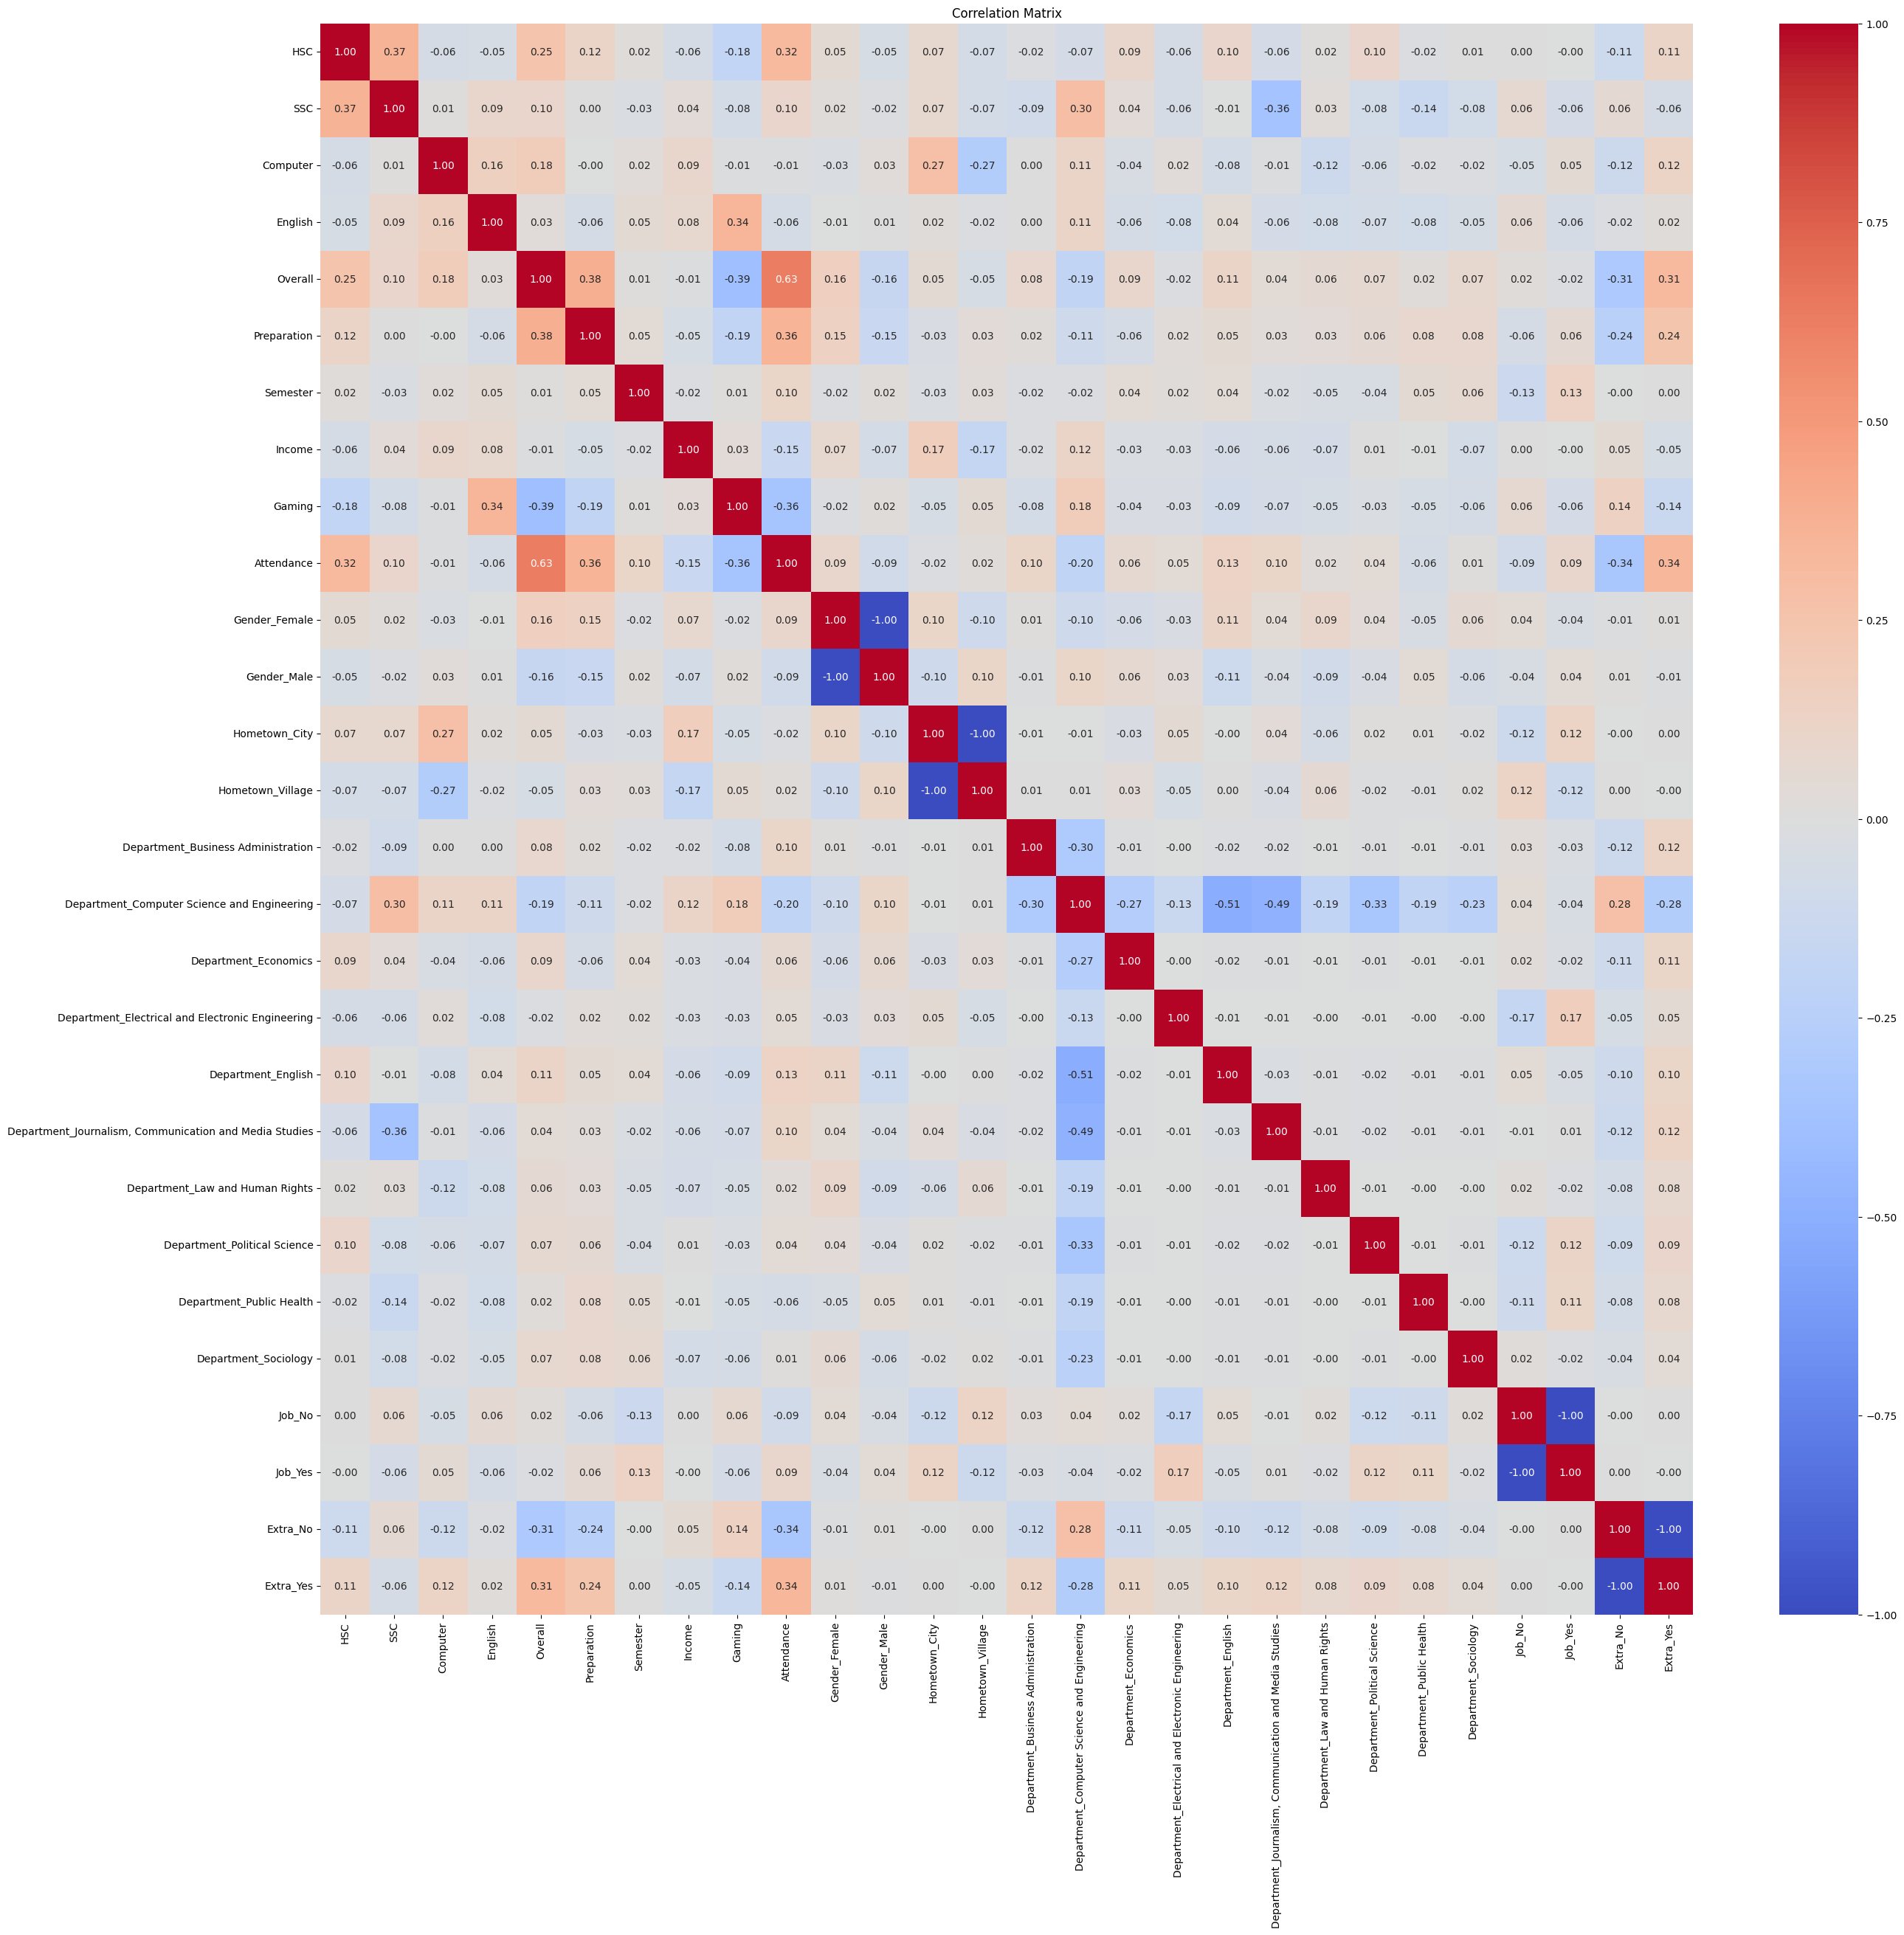

In [28]:
# 2. Compute the correlation matrix
corr = df_processed.corr(numeric_only=True)

# 3. Plot the correlation heatmap
plt.figure(figsize=(30, 28))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

In [29]:
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor

In [30]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

X = df_processed.drop('Overall', axis=1)
y = df_processed['Overall']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

X_scaled = scaler.fit_transform(X)

In [31]:
from sklearn.compose import ColumnTransformer


X = df_processed.drop('Overall', axis=1)
y = df_processed['Overall']

X_scaled = scaler.fit_transform(X)

In [32]:
model_lr = LinearRegression()
model_lr.fit(X_train, y_train)

model_svm = SVR(kernel='rbf', C=10, gamma='scale')
model_svm.fit(X_train, y_train)

model_dt = DecisionTreeRegressor(max_depth=6, random_state=42)
model_dt.fit(X_train, y_train)

,criterion,'squared_error'
,splitter,'best'
,max_depth,6
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,42
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,ccp_alpha,0.0


In [33]:
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np

def evaluate(model, name):
    y_pred = model.predict(X_test)
    print(f"---- {name} ----")
    print("R²:", r2_score(y_test, y_pred))
    print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
    print()

evaluate(model_lr, "Linear Regression")
evaluate(model_svm, "SVM Regression")
evaluate(model_dt, "Decision Tree Regression")

---- Linear Regression ----
R²: 0.4140559525439992
RMSE: 0.46770535101326705

---- SVM Regression ----
R²: 0.5086316929538056
RMSE: 0.42829976491833244

---- Decision Tree Regression ----
R²: 0.4598557282200155
RMSE: 0.4490546033073171



In [35]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(
    n_estimators=300,
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train, y_train)

importances = rf.feature_importances_
feature_names = X.columns

# Sort features by importance
# [::-1] reverses the order of sorted features
indices = np.argsort(importances)[::-1]

print("Feature Importances:")
for idx in indices:
    print(f"{feature_names[idx]}: {importances[idx]:.4f}")

Feature Importances:
Attendance: 0.3640
Preparation: 0.2002
English: 0.0729
Semester: 0.0626
HSC: 0.0604
Computer: 0.0575
SSC: 0.0471
Income: 0.0276
Gaming: 0.0236
Department_Computer Science and Engineering: 0.0233
Hometown_Village: 0.0086
Extra_Yes: 0.0080
Gender_Male: 0.0070
Hometown_City: 0.0066
Extra_No: 0.0065
Gender_Female: 0.0063
Department_Journalism, Communication and Media Studies: 0.0050
Job_Yes: 0.0033
Job_No: 0.0033
Department_Economics: 0.0019
Department_Law and Human Rights: 0.0011
Department_Sociology: 0.0010
Department_English: 0.0010
Department_Electrical and Electronic Engineering: 0.0007
Department_Business Administration: 0.0002
Department_Political Science: 0.0002
Department_Public Health: 0.0001


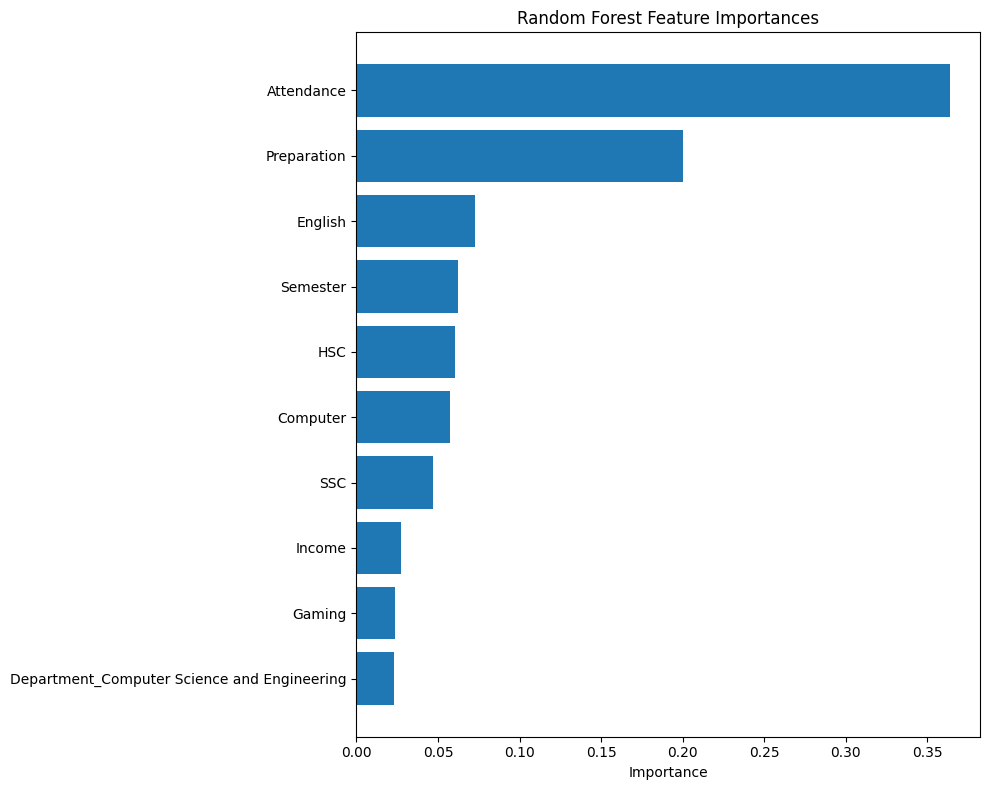

In [36]:
N = 10
top_indices = indices[:N]

plt.figure(figsize=(10, 8))
plt.barh(range(len(top_indices)), importances[top_indices][::-1])
plt.yticks(range(len(top_indices)), feature_names[top_indices][::-1])
plt.xlabel("Importance")
plt.title("Random Forest Feature Importances")
plt.tight_layout()
plt.show()